In [1]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

c:\Users\Mouadh Fraj\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
BATCH_SIZE = 32
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "ROI_data",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
)
ds = ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000)




Found 2830 files belonging to 2 classes.


In [5]:
resnet_model = Sequential()
pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in pretrained_model.layers:
    layer.trainable = True

In [6]:
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))  
custom_optimizer = Adam(learning_rate=0.001)
resnet_model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy']) 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74968961 (285.98 MB)
Trainable params: 74915841 (285.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [7]:
epochs = 5
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5


 8/71 [==>...........................] - ETA: 37:16 - loss: 14.5526 - accuracy: 0.4883

: 

In [37]:
scores =resnet_model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9243 - loss: 0.1959


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2024-03-26 23:07:26.608685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


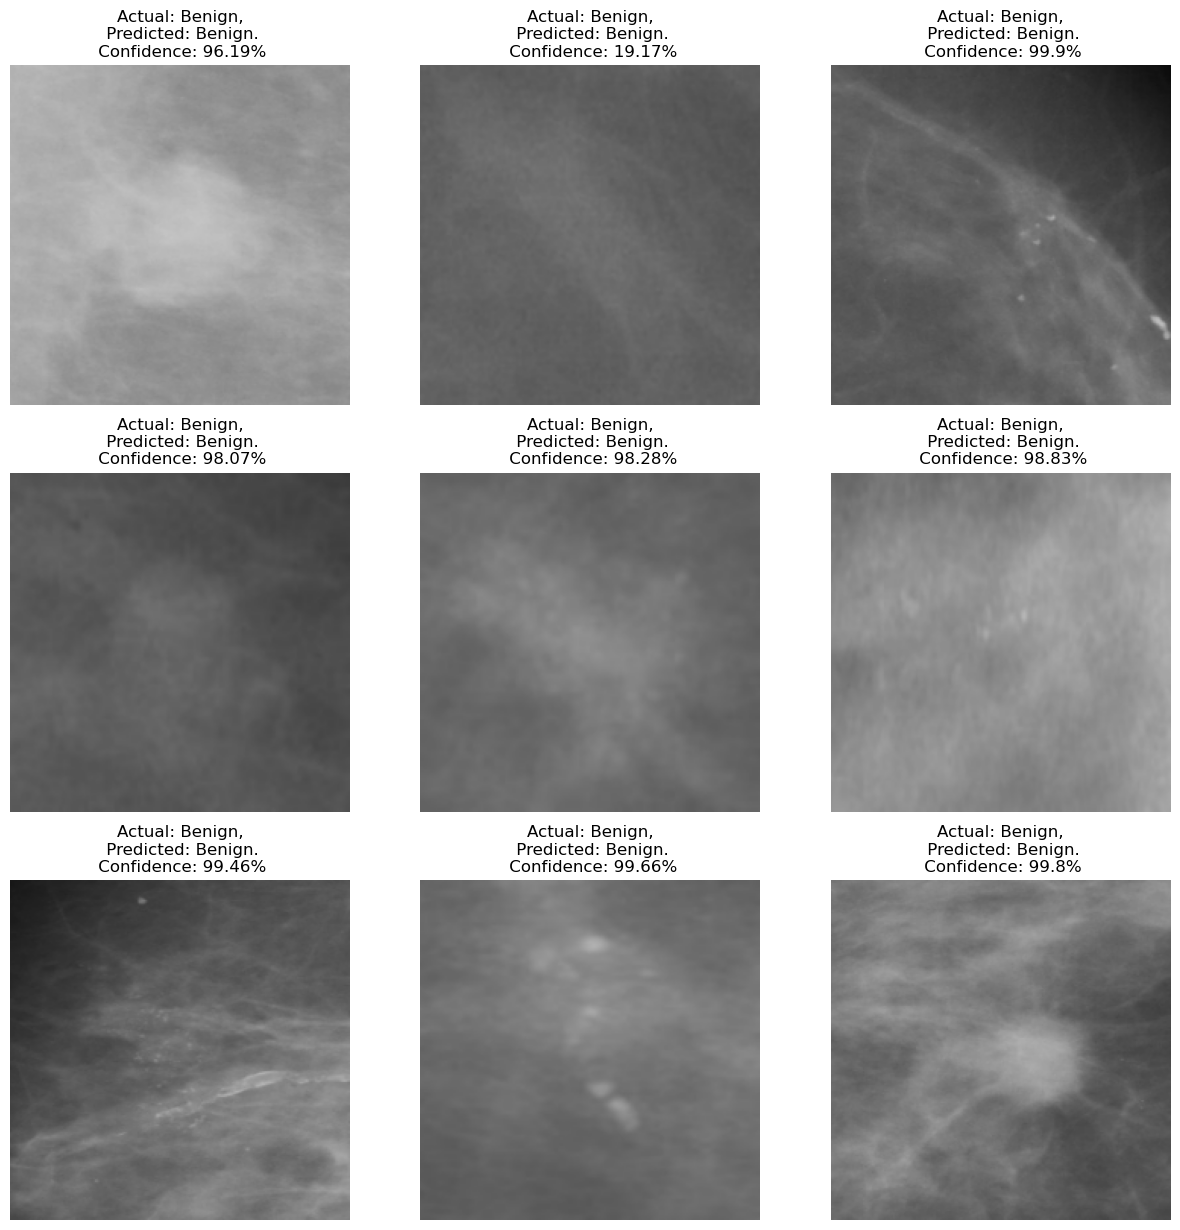

In [47]:
import matplotlib.pyplot as plt
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    return predictions
class_names = ['Benign','Cancer']  
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = predict(resnet_model, images[i].numpy())
        predicted_class_index = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_index]
        confidence = round(100 * np.max(predictions[0]), 2)
        actual_class_index = np.argmax(labels[i].numpy())
        actual_class = class_names[actual_class_index] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

plt.show()

In [61]:
import numpy as np
from tensorflow.keras.preprocessing import image
IMAGE_SIZE = (224, 224)

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  
    return img_array
image_path = '/Users/macbook/Desktop/pcd2/AAA_4053_1.LEFT_CC.jpg'
preprocessed_image = preprocess_image(image_path)
predictions = resnet_model.predict(preprocessed_image)
predicted_class = predictions[0][0]  
class_names = ['Benign','Cancer']
predicted_class_name = class_names[int(round(predicted_class))]
confidence = predicted_class

print("Predicted class:", predicted_class_name)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Predicted class: Benign
Confidence: 0.48029888


In [64]:
pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
for layer in model.layers[0].layers[-10:]:
    layer.trainable = True
custom_optimizer = Adam(learning_rate=0.0001)  
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, epochs=5, validation_data=val_ds)



Epoch 1/5


2024-03-26 23:32:34.390155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:980: Filling up shuffle buffer (this may take a while): 80 of 10000
2024-03-26 23:32:35.288099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/71 ━━━━━━━━━━━━━━━━━━━━ 20:13 26s/step - accuracy: 0.5045 - loss: 2.7849

KeyboardInterrupt: 

In [10]:
scores =resnet_model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9839 - loss: 0.0760


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


2024-03-26 21:24:33.378352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


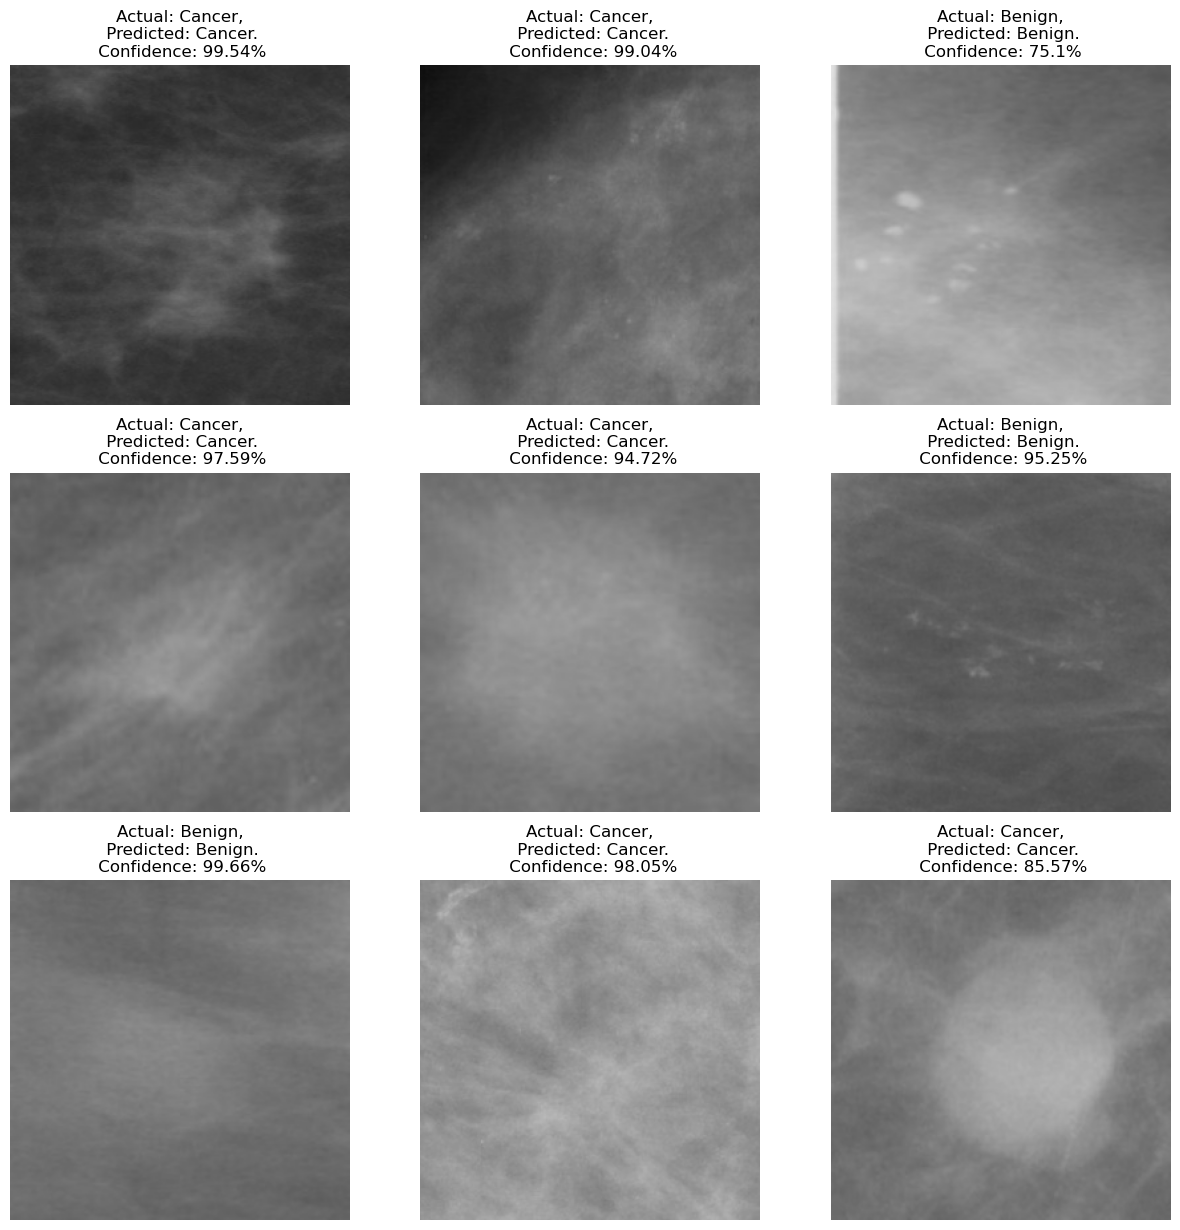

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    return predictions


class_names = ['Benign','Cancer']  


plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predictions = predict(resnet_model, images[i].numpy())
        predicted_class_index = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_index]
        confidence = round(100 * np.max(predictions[0]), 2)
        actual_class_index = np.argmax(labels[i].numpy())
        actual_class = class_names[actual_class_index]
        
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  
    return img_array
image_path = '/Users/macbook/Desktop/pcd2/MINI-DDSM-Complete-JPEG-8/Roi_data/Cancer/A_1401_1.RIGHT_CC.jpg'
preprocessed_image = preprocess_image(image_path)
predictions = resnet_model.predict(preprocessed_image)

predicted_class = np.argmax(predictions[0])  
class_names = ['Benign','Cancer'] 
predicted_class_name = class_names[predicted_class]
confidence = predictions[0][predicted_class]

print("Predicted class:", predicted_class_name)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predicted class: Benign
Confidence: 0.9802051
